In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import sys
import os

from ExptTrace import ExptTrace
from FileManager import FileManager
from misc import rcsetup

rcsetup()

sys.path.append("../")

from kernels import GaussianKernel, LaplaceKernel
from utils import ensure_torch, ensure_numpy, Hyperparams
from eigenlearning import eigenlearning

kerneltype_dict = {
    "GaussianKernel": GaussianKernel,
    "LaplaceKernel": LaplaceKernel,
}

In [2]:
import importlib
import eigenlearning
importlib.reload(eigenlearning)
from eigenlearning import eigenlearning

In [3]:
hypers = Hyperparams(
    expt_name = "hehe-eigenlearning",
    dataset = "gaussian",
    kernel_name = "GaussianKernel",
    kernel_width = 4,
    n_samples = 20_000,
    p_modes = 20_000,
    # If using synth data, set these
    data_dim = 200,
    data_eigval_exp = 1.2,
    # If using natural image data, set these
    zca_strength = 5e-3,
)

In [4]:
# SETUP FILE MANAGEMENT
#######################

exptpath = os.getenv("EXPTPATH")
if exptpath is None:
    raise ValueError("must set $EXPTPATH environment variable")
expt_dir = os.path.join(exptpath, "phlab", hypers.expt_name, hypers.dataset)
expt_dir = os.path.join(expt_dir, hypers.generate_filepath())

if not os.path.exists(expt_dir):
    assert False
expt_fm = FileManager(expt_dir)

In [18]:
import matplotlib.colors as mcolors

colors = ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"]

def lighten(color, amount=0.5):
    rgb = mcolors.to_rgb(mcolors.XKCD_COLORS.get(color, color))
    if amount >= 0:
        new_rgb = tuple(c + (1 - c) * amount for c in rgb)
    else:
        new_rgb = tuple(c * (1 + amount) for c in rgb)
    # Clip values to [0, 1]
    new_rgb = tuple(min(max(x, 0), 1) for x in new_rgb)
    return new_rgb

In [25]:
targets = expt_fm.load("targets.pickle")
target = sorted(targets.keys())[1]
print(target)
ystar = targets[target]

result = expt_fm.load("result.pickle")
monomials = result["monomials"]
d_eff = result["d_eff"]
et_yhat = ExptTrace.deserialize(result["y_hat"])

emp_eigvals = result["emp_eigvals"]
emp_eigvecs = expt_fm.load("emp_eigvecs.npy")
emp_coeffs = emp_eigvecs.T @ ystar
emp_coeffs /= np.linalg.norm(emp_coeffs)

hehe_eigvals = result["th_eigvals"]
H = expt_fm.load("H.npy")
hehe_coeffs = torch.linalg.lstsq(ensure_torch(H), ensure_torch(ystar))[0]
hehe_coeffs = ensure_numpy(hehe_coeffs)
hehe_coeffs /= np.linalg.norm(hehe_coeffs)

ntest = result["n_test"]
ridges = et_yhat.get_axis("ridge")
ntrains = et_yhat.get_axis("ntrain")
trials = et_yhat.get_axis("trial")

1.25


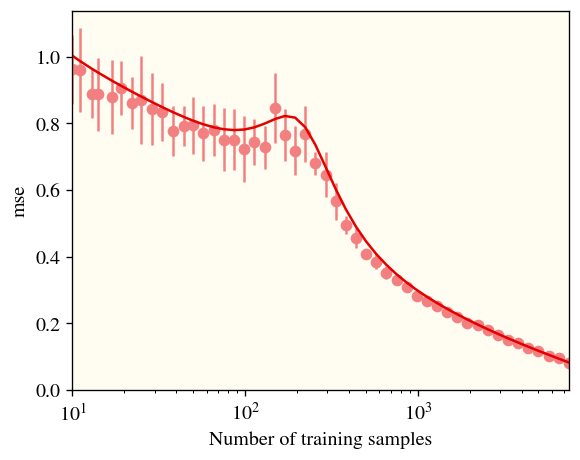

In [26]:
def get_mse_stats(ntrain, ridge):
    yhat_trials = []
    for t in trials:
        try:
            yhat = et_yhat.get(ntrain=ntrain, ridge=ridge, trial=t, target=target)
            yhat_trials.append(yhat.squeeze())
        except AssertionError:
            continue
    mse = ((np.array(yhat_trials) - ystar[-ntest:])**2).mean(axis=1)
    return mse.mean(axis=0), mse.std(axis=0)

mse_stats = np.array([[get_mse_stats(n, ridges[0])] for n in ntrains]).squeeze()
mse_mean, mse_std = mse_stats[:, 0], mse_stats[:, 1]

# do_el = lambda n: eigenlearning(n, emp_eigvals, emp_coeffs, ridge=ridges[0])
# do_el = lambda n: eigenlearning(n, hehe_eigvals[:], hehe_coeffs, ridge=ridges[0])
do_el = lambda n: eigenlearning(n, hehe_eigvals[:], hehe_coeffs, ridge=ridges[0])
mse_el = np.array([do_el(n)["test_mse"] for n in ntrains])

fig, ax = plt.subplots(figsize=(5, 4))
c = lighten(colors[0], 0.5)
ax.errorbar(ntrains, mse_mean, yerr=mse_std, color=c, ls='none', marker='o', zorder=-4)
ax.plot(ntrains, mse_el, color=colors[0])
ax.set_xlabel("Number of training samples")
ax.set_ylabel("mse")
ax.set_xlim(ntrains[0], ntrains[-1])
ax.set_ylim(0)

ax.set_xscale("log")
plt.tight_layout()
plt.show()

In [80]:
el_hehe = eigenlearning(100, hehe_eigvals[:20000], hehe_coeffs, ridge=ridges[0])
el_emp = eigenlearning(100, emp_eigvals, hehe_coeffs, ridge=ridges[0])

print(el_hehe["kappa"], el_emp["kappa"])

import scipy
def eigenlearning2(n, eigvals, eigcoeffs, ridge=0, noise_var=0):

    def solve_kappa(n, eigvals, ridge):
        conservation_law = lambda kap: (eigvals/(eigvals+kap)).sum() + ridge/kap - n
        kappa = scipy.optimize.bisect(conservation_law, 1e-25, 1e10, maxiter=128)
        return kappa

    kappa = solve_kappa(n, emp_eigvals, ridge) # bruh
    learnabilities = eigvals / (eigvals + kappa)
    e0 = n / (n - (learnabilities**2).sum())
    lrn_trunc = learnabilities
    if len(eigcoeffs) <= len(learnabilities):
        lrn_trunc = learnabilities[:len(eigcoeffs)]
    test_mse = e0 * (((1-lrn_trunc)**2 * eigcoeffs**2).sum() + noise_var)
    train_mse = (ridge / (n * kappa))**2 * test_mse
    L = (eigcoeffs**2 * lrn_trunc).sum() / (eigcoeffs**2).sum()

    return {
        "kappa": kappa,
        "learnabilities": learnabilities,
        "overfitting_coeff": e0,
        "target_learnability": L,
        "train_mse": train_mse,
        "test_mse": test_mse,
    }
    


0.000798336715008416 0.00181893725342136


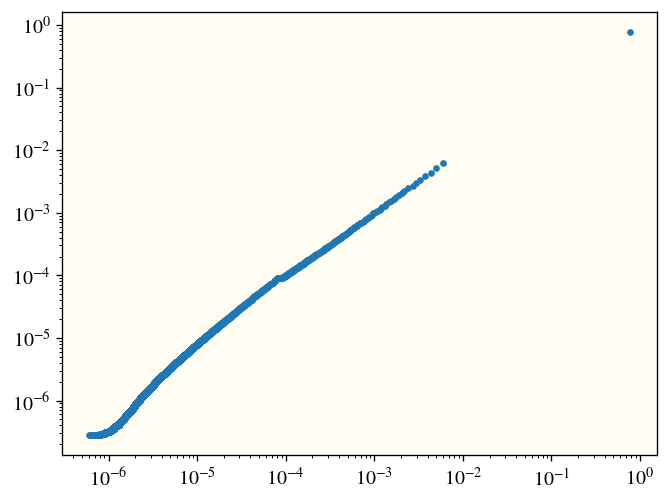

In [93]:
plt.scatter(emp_eigvals-3.2e-6, hehe_eigvals[:len(emp_eigvals)], marker='.')
plt.xscale("log")
plt.yscale("log")
plt.show()

# Old stuff

In [3]:
# TOP LEVEL HYPERPARAMS
#######################

EXPT_NAME = "hehe-eigenlearning"
DATASET = "gaussian"

N_SAMPLES = 20_000
P_MODES = 10_000
DATA_DIM = 200

# SETUP FILE MANAGEMENT
#######################

datapath = os.getenv("DATASETPATH")
exptpath = os.getenv("EXPTPATH")
if datapath is None:
    raise ValueError("must set $DATASETPATH environment variable")
if exptpath is None:
    raise ValueError("must set $EXPTPATH environment variable")
expt_dir = os.path.join(exptpath, "phlab", EXPT_NAME, DATASET)

if not os.path.exists(expt_dir):
    os.makedirs(expt_dir)
expt_fm = FileManager(expt_dir)

In [4]:
def emp_eigsys(kernel, y):
    eigvals, eigvecs = kernel.eigendecomp()
    eigcoeffs = eigvecs.T @ y
    eigcoeffs /= torch.linalg.norm(eigcoeffs)
    eigvals = eigvals.cpu().numpy()
    eigcoeffs = eigcoeffs.cpu().numpy()

    return eigvals, eigcoeffs


def fra_eigsys(X, y, eval_level_coeff):
    N, _ = X.shape
    S = torch.linalg.svdvals(X)
    data_eigvals = S**2 / (S**2).sum()

    eigvals, monomials = generate_fra_monomials(data_eigvals, N, eval_level_coeff, kmax=10)
    H = get_matrix_hermites(X, monomials)
    eigcoeffs = torch.linalg.lstsq(H, y).solution
    eigcoeffs /= torch.linalg.norm(eigcoeffs)
    eigcoeffs = eigcoeffs.cpu().numpy()

    return eigvals, eigcoeffs


def learning_curve(ntrains, eigvals, eigcoeffs, ridge=0, noise_var=0):
    kappas, learnabilities, e0s, train_mses, test_mses = [np.zeros(len(ntrains)) for _ in range(5)]
    for i, n in enumerate(ntrains):
        res = eigenlearning(n, eigvals, eigcoeffs, ridge, noise_var)
        # kappas[i] = res["kappa"]
        # learnabilities[i] = res["learnability"]
        # e0s[i] = res["overfitting_coeff"]
        train_mses[i] = res["train_mse"]
        test_mses[i] = res["test_mse"]
    return train_mses, test_mses

In [5]:
data_eigval_exps = np.linspace(1., 2., num=3)
zca_strengths = [0, 5e-3, 3e-2]
kerneltypes = [GaussianKernel, LaplaceKernel]
kernel_widths = [1, 4]

var_axes = ["d_eff", "kernel", "kernel_width"]
et_pathnames, et_emp_eigvals, et_fra_eigvals = ExptTrace.multi_init(3, var_axes)

if DATASET == "cifar10":
    data_dir = os.path.join(datapath, "cifar10")
    cifar10 = ImageData('cifar10', data_dir, classes=None)
    X_raw, _ = cifar10.get_dataset(N_SAMPLES, get="train")
if DATASET == "imagenet32":
    fn = os.path.join(datapath, "imagenet", f"{DATASET}.npz")
    data = np.load(fn)
    X_raw = data['data'][:N_SAMPLES].astype(float)
    X_raw = rearrange(X_raw, 'n (c h w) -> n c h w', c=3, h=32, w=32)


# Gaussian data

In [14]:
data_eigval_exp = data_eigval_exps[0]
data_eigvals = get_powerlaw(DATA_DIM, data_eigval_exp, offset=6)
X = get_gaussian_data(N_SAMPLES, data_eigvals)

d_eff = 1/(data_eigvals**2).sum()

# create kernel
print("Creating kernel")

kerneltype = GaussianKernel
kwidth = 4
kernel = kerneltype(X, kernel_width=kwidth)

# Generate synthetic target
print("Generating synthetic target")

eval_level_coeff = kerneltype.get_level_coeff_fn(data_eigvals, kernel_width=kwidth)
eigvals, monomials = generate_fra_monomials(data_eigvals, P_MODES, eval_level_coeff)
H = get_matrix_hermites(X, monomials)

beta = 1.1
noise_var = 2e-1
squared_coeffs = get_powerlaw(P_MODES, beta, offset=6)
y, snr = get_hermite_target(H, squared_coeffs, noise_var=noise_var)

print(f"SNR = {snr}")

Creating kernel
Generating synthetic target
SNR = 5.055937767028809


In [15]:
ntrains = np.logspace(1, 4, base=10, num=20).astype(int)
et_test_mse = ExptTrace(["trial", "n"])
et_train_mse = ExptTrace(["trial", "n"])
ystar_idx = 5
ridge = 1e-3
ntrials = 5

K = ensure_torch(kernel.K)

for trial in tqdm(range(ntrials)):
    for ntrain in ntrains:
        train_mse, test_mse, yhattest = krr(K, y, ntrain, n_test=2000, ridge=ridge)
        et_test_mse[trial, ntrain] = test_mse
        et_train_mse[trial, ntrain] = train_mse


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


# Cifar 10

In [ ]:
classes = [[0], [1]]
NTRAIN = 10_000
NTEST = 2_000

cifar10 = ImageData('cifar10', DATA_PATH, classes=classes)
X_train, y_train = cifar10.get_dataset(NTRAIN, get="train")
X_test, y_test = cifar10.get_dataset(NTEST, get="test")
X_train, y_train, X_test, y_test = [torch.Tensor(t) for t in (X_train, y_train, X_test, y_test)]
X_raw = torch.cat([X_train, X_test])
y = torch.cat([y_train, y_test])
y -= y.mean()
y = y[:,0]-y[:,1]

X = preprocess(X_raw, center=True, grayscale=True, zca_strength=0)
X = to_torch(X)

N, _ = X.shape
S = torch.linalg.svdvals(X)
# to make norm(x)~1 on average
X *= torch.sqrt(N / (S**2).sum())
data_eigvals = S**2 / (S**2).sum()

print(f"d_eff={1/(data_eigvals**2).sum().item():.2f}")

Files already downloaded and verified
Files already downloaded and verified
d_eff=6.60


In [13]:
X = preprocess(X_raw, center=True, grayscale=True, zca_strength=.02)
X = to_torch(X)
S = torch.linalg.svdvals(X)
print(f"d_eff={(S**2).sum().item()**2/(S**4).sum().item():.2f}")

d_eff=38.20
